In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
import copy
import datetime


from functools import lru_cache, partial
from pprint import pprint



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from environments.environments import (
                                     NeuralForecastingTradingEnv)

from tqdm.autonotebook import tqdm

from utils.utils import ( build_market_image,prep_forecasts,sharpe_reward)

import onnx
from neuralforecast.core import NeuralForecast


In [27]:

target_pair='USD_JPY'
time_frame="1h"
symbol=target_pair.replace('_','')
symbol

'USDJPY'

In [28]:
model=NeuralForecast.load("FX_Forecasting_model")

Seed set to 2
Seed set to 16
Seed set to 8
Seed set to 5


In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
data=build_market_image(target_pair=symbol,time_frame='1h',axis=0,dir='data_forex')
data=data[data['symbol']==target_pair].copy()
data['ds']=data.index
data

,open,high,low,close,volume,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,...,feature_log_volume_15,feature_log_return_20,feature_log_volume_20,feature_log_return_25,feature_log_volume_25,feature_log_return_30,feature_log_volume_30,ds,unique_id,symbol
date_close,,,,,,,,,,,,,,,,,,,,,
2022-01-02 22:00:00,115.118,115.155,115.084,115.125,231,115.125,0.456522,0.5,-0.466667,-0.497260,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-02 22:00:00,20,USD_JPY
2022-01-02 23:00:00,115.110,115.158,115.099,115.144,848,115.144,0.500000,0.5,-0.466667,-0.497260,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-02 23:00:00,20,USD_JPY
2022-01-03 00:00:00,115.142,115.294,115.124,115.280,1771,115.280,-0.500000,-0.5,-0.433333,-0.494521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-03 00:00:00,20,USD_JPY
2022-01-03 01:00:00,115.279,115.280,115.182,115.213,1401,115.213,-0.456522,-0.5,-0.433333,-0.494521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-03 01:00:00,20,USD_JPY
2022-01-03 02:00:00,115.214,115.279,115.207,115.278,946,115.278,-0.413043,-0.5,-0.433333,-0.494521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-01-03 02:00:00,20,USD_JPY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17 14:00:00,157.888,157.962,157.832,157.856,6254,157.856,0.108696,-0.5,0.033333,-0.039726,...,0.935094,0.003656,0.559256,0.003668,-0.456785,0.002302,-0.822412,2024-06-17 14:00:00,20,USD_JPY
2024-06-17 15:00:00,157.857,157.894,157.784,157.811,4218,157.811,0.152174,-0.5,0.033333,-0.039726,...,-0.645565,0.003205,0.630656,0.002728,-1.093065,0.004528,-1.144863,2024-06-17 15:00:00,20,USD_JPY
2024-06-17 16:00:00,157.812,157.818,157.729,157.784,3513,157.784,0.195652,-0.5,0.033333,-0.039726,...,-0.285545,0.002379,0.478982,0.003155,-0.667194,0.005236,-1.427697,2024-06-17 16:00:00,20,USD_JPY


In [31]:
split_date=datetime.datetime(year= 2024, month= 4, day=1)
end_date=split_date+datetime.timedelta(days=14)


hf_data=data.copy()

hf_train_data=hf_data.groupby('symbol').apply(lambda x: x[:split_date])
hf_test_data=hf_data.groupby('symbol').apply(lambda x: x[split_date:])

hf_train_data=hf_train_data.reset_index(level=0,drop=True).reset_index()
hf_test_data=hf_test_data.reset_index(level=0,drop=True).reset_index()


trade_data=data[data['symbol']==target_pair].copy()
train_data=trade_data[:split_date]
test_data=trade_data[split_date:end_date]
# hf_test_data

In [32]:
train_data.head(5)

,open,high,low,close,volume,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,...,feature_log_volume_15,feature_log_return_20,feature_log_volume_20,feature_log_return_25,feature_log_volume_25,feature_log_return_30,feature_log_volume_30,ds,unique_id,symbol
date_close,,,,,,,,,,,,,,,,,,,,,
2022-01-02 22:00:00,115.118,115.155,115.084,115.125,231,115.125,0.456522,0.5,-0.466667,-0.497260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-02 22:00:00,20,USD_JPY
2022-01-02 23:00:00,115.110,115.158,115.099,115.144,848,115.144,0.500000,0.5,-0.466667,-0.497260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-02 23:00:00,20,USD_JPY
2022-01-03 00:00:00,115.142,115.294,115.124,115.280,1771,115.280,-0.500000,-0.5,-0.433333,-0.494521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-03 00:00:00,20,USD_JPY
2022-01-03 01:00:00,115.279,115.280,115.182,115.213,1401,115.213,-0.456522,-0.5,-0.433333,-0.494521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-03 01:00:00,20,USD_JPY
2022-01-03 02:00:00,115.214,115.279,115.207,115.278,946,115.278,-0.413043,-0.5,-0.433333,-0.494521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-03 02:00:00,20,USD_JPY


In [33]:
train_forecast_array,train_df=prep_forecasts(model=model,df=train_data)
test_forecast_array,test_df=prep_forecasts(df=test_data,model=model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
train_env_config=dict(
                name=f'{symbol}_train',
                forecast_horizon=7,
                context_length=35,
                # initial_position=0,
                reward_function=sharpe_reward,
                forecasts=train_forecast_array,
                df = train_df, # Your dataset with your custom features
                positions = [ -.5,-.25,.25, .5], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
                trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
                borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
                max_episode_duration=168,
                verbose=0
                )

test_env_config=copy.deepcopy(train_env_config)
test_env_config['name']=f'{symbol}_test'
test_env_config['df'] = test_df
test_env_config['forecasts']=test_forecast_array



In [35]:
train_env=NeuralForecastingTradingEnv(**train_env_config)

In [36]:
obs=train_env.reset()
terminated = truncated = False
# env.action_space.sa
while not terminated and not truncated:
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
info['reward']
# train_env.results_metrics
# train_env.historical_info.columns

0.030487022903825902

In [37]:
pickle_cp_dir=f'FX_Agent/{target_pair}production_checkpoint'
prod_cp_dir=f'FX_Agent/{target_pair}_production_agent'
prod_onnx_dir=f'FX_Agent/{target_pair}production_agent_onnx'

In [38]:
onnx_model = onnx.load(prod_onnx_dir+'/model.onnx')
onnx.checker.check_model(onnx_model)

In [39]:
test_env=NeuralForecastingTradingEnv(**test_env_config)

In [40]:
import onnxruntime as ort

In [41]:
ort_sess = ort.InferenceSession(prod_onnx_dir+'/model.onnx')


In [42]:
input1=ort_sess.get_inputs()[0]
input1.shape


['batch_size', 53]

In [43]:
obs,info=test_env.reset()

input_dict={'obs': np.array([obs]),'state_ins':np.zeros(1,dtype=np.float32)}
input_dict

{'obs': array([[ 1.5193752e+02,  5.3611045e+00,  1.5168823e+02,  1.5191766e+02,
          1.5178799e+02,  1.5192845e+02,  5.4226165e+00,  1.5167458e+02,
          1.5192111e+02,  1.5167900e+02,  1.5192082e+02,  5.4219122e+00,
          1.5171550e+02,  1.5192213e+02,  1.5164799e+02,  1.5192084e+02,
          5.3980851e+00,  1.5167067e+02,  1.5193321e+02,  1.5168201e+02,
          1.5192412e+02,  5.4434590e+00,  1.5169089e+02,  1.5192093e+02,
          1.5167300e+02,  1.5192868e+02,  5.4471164e+00,  1.5171416e+02,
          1.5191307e+02,  1.5168401e+02,  6.5217391e-02, -1.6666667e-01,
         -4.3333334e-01, -2.4520548e-01,  1.5164951e+02,  1.5165192e+02,
          1.5144998e+02,  9.7465893e-04,  7.5115055e-01,  1.2514244e-03,
          8.1185699e-01,  2.3724490e-03,  1.0653594e+00,  2.4252341e-03,
          1.6012884e+00,  2.3328620e-03,  1.0125663e+00,  1.5216742e-03,
          1.1940547e-01,  1.6337505e-03,  1.6332754e-01,  5.0000000e-01,
          5.0000000e-01]], dtype=float32),
 

In [44]:

outputs = ort_sess.run(None,input_dict)
outputs
state=outputs[-1]
action_proba=outputs[0]
action=int(np.argmax(action_proba))
action

2

In [45]:
eval_profit=[]
eval_market=[]
for i in tqdm( range(100)):
    obs,info=test_env.reset()
    states=np.ones(1,dtype=np.float32)
    action=None
    reward=0
    terminated = truncated = False

    while not terminated and not truncated:

        input_dict={'obs': np.array([obs]),'state_ins':states}
        outputs = ort_sess.run(None,input_dict)

        states=outputs[-1]
        action_proba=outputs[0]
        action=int(np.argmax(action_proba))
        

        # action = train_env.action_space.sample()
        # print(action)
        next_obs, reward, terminated, truncated, info = test_env.step(action)

        obs=next_obs
    metrics=test_env.get_metrics()
    eval_market.append(float(metrics['Market Return'].replace('%','')))
    eval_profit.append(float(metrics['Portfolio Return'].replace('%','')))

    # info['portfolio_valuation']

  0%|          | 0/100 [00:00<?, ?it/s]

(0.188, 0.7585999999999999)

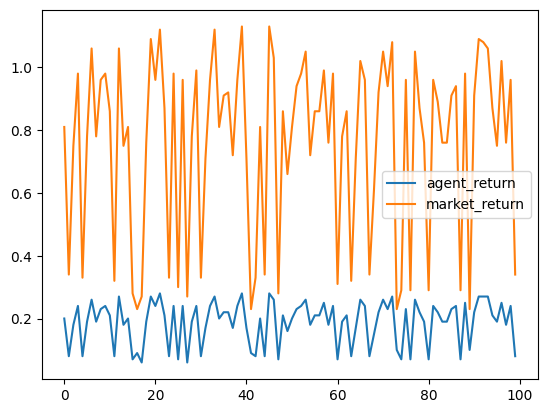

In [46]:

plt.plot(eval_profit,label='agent_return')
plt.plot(eval_market,label='market_return')
plt.legend()
np.mean(eval_profit),np.mean(eval_market)

In [47]:
obs,info=test_env.reset()
action=None
reward=0
terminated = truncated = False
states=np.zeros(1,dtype=np.float32)

while not terminated and not truncated:

    input_dict={'obs': np.array([obs]),'state_ins':states}
    outputs = ort_sess.run(None,input_dict)

    states=outputs[-1]

    action_proba=outputs[0]
    action = int(np.argmax(action_proba))
    # print(action)
    next_obs, reward, terminated, truncated, info = test_env.step(action)

    obs=next_obs
info['reward'],info[ 'portfolio_valuation'],test_env.get_metrics()




(0.07157916623840194,
 1001.7182121673844,
 {'Market Return': ' 0.71%',
  'Portfolio Return': ' 0.17%',
  'Position Changes': 1,
  'Episode Length': 168})

In [26]:
ort_sess.get_outputs

<bound method Session.get_outputs of <onnxruntime.capi.onnxruntime_inference_collection.InferenceSession object at 0x2894b9ab0>>